# Experiments 6:
### generating byte frequency distributions derived from file last blocks to train and evaluate our models - FFNN, CNN, GRU, LSTM

In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.utils import get_file_types, get_last_block_bytes, convert_cat2num, byte_frequency_histogram
from toolkit.models import Ffnn, Ffnn2, Cnn, Cnn2, Lstm, Gru
from toolkit.metrics import evaluate_performance, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Preparation

In [2]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

In [3]:
df['size KB'] = df['file'].apply(
    lambda x: float(os.path.getsize(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) / 1024.0) if os.path.isfile(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) else None
)

print(f"The average file size is: {df['size KB'].mean()}")

The average file size is: 519.8767892054933


In [4]:
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [5]:
df = df[df['type'].isin(CLASS_NAMES)]
df = df[df['size KB'] > 8]

In [6]:
df = df.groupby('type').apply(
    lambda x: x if x.name == "png" else x.sample(n=min(len(x), 2000), random_state=42)
).reset_index(drop=True)

df["type"].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_28184\603527055.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(


type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
png     1650
Name: count, dtype: int64

In [7]:
base_dir = os.path.join(os.getcwd(), "govdocs1")
df["last_block_bytes"] = df.apply(
    lambda row: get_last_block_bytes(
        path=os.path.join(base_dir, row["file"]), 
        file_size_kb=row["size KB"]
    ), 
    axis=1
)
df["byte_bfh"] = df["last_block_bytes"].apply(
    lambda byte_sequence: byte_frequency_histogram(np.array([byte for byte in byte_sequence]))
)

In [8]:
byte_lengths = df["byte_bfh"].apply(len)
all_same_length = byte_lengths.nunique() == 1

print("byte lengths of each sequence:\n", byte_lengths)
print("all byte sequences of the same length:", all_same_length)

byte lengths of each sequence:
 0        256
1        256
2        256
3        256
4        256
        ... 
23645    256
23646    256
23647    256
23648    256
23649    256
Name: byte_bfh, Length: 23650, dtype: int64
all byte sequences of the same length: True


In [9]:
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))

In [10]:
df.sample(n=5)

,file,type,size KB,last_block_bytes,byte_bfh,class
2173,591957.gif,gif,29.300781,b'U\x8d\x9a\xe3\xc4\xbe\xae0\xea^\xcf\xbd\t\xd...,"[3, 3, 2, 2, 2, 2, 6, 5, 2, 6, 3, 3, 3, 5, 3, ...",7
16098,642777.swf,swf,501.567383,b'\x07\x06\x00@\x00\x00\x00\xbf\x06\x1a\x00\x0...,"[388, 39, 75, 15, 19, 14, 28, 28, 97, 6, 4, 5,...",6
20464,169274.xls,xls,23.000000,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"[2542, 7, 6, 2, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, ...",4
4286,026680.html,html,27.201172,b'istration\n<br><b>Latest Major Action:</b> 9...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0,...",10
21295,738351.xls,xls,16.500000,b'R\x00o\x00o\x00t\x00 \x00E\x00n\x00t\x00r\x0...,"[382, 5, 5, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1...",4


In [11]:
X = np.array([x for x in df["byte_bfh"]])
y = np.array([y for y in df["class"]])

In [12]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (23650, 256)
y shape:  (23650,)


In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
print("X training shape: ", X_train.shape)
print("X validation shape: ", X_val.shape)
print("X testing shape: ", X_test.shape, "\n")
print("y training shape: ", y_train.shape)
print("y validation shape: ", y_val.shape)
print("y testing shape: ", y_test.shape)

X training shape:  (16555, 256)
X validation shape:  (3547, 256)
X testing shape:  (3548, 256) 

y training shape:  (16555,)
y validation shape:  (3547,)
y testing shape:  (3548,)


## 2. Models Training and Evaluation

### Feed Forward Neural Network

#### a. Base FFNN

In [15]:
ffnn = Ffnn(timesteps=256, features=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256, 256)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │       425,997 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,405 (1.75 MB)

 Trainable params: 459,405 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
ffnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.6515 - loss: 1.1267 - val_accuracy: 0.8131 - val_loss: 0.5042
Epoch 2/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8411 - loss: 0.4555 - val_accuracy: 0.8469 - val_loss: 0.4247
Epoch 3/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8676 - loss: 0.3931 - val_accuracy: 0.8692 - val_loss: 0.3837
Epoch 4/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8936 - loss: 0.3130 - val_accuracy: 0.8421 - val_loss: 0.4409


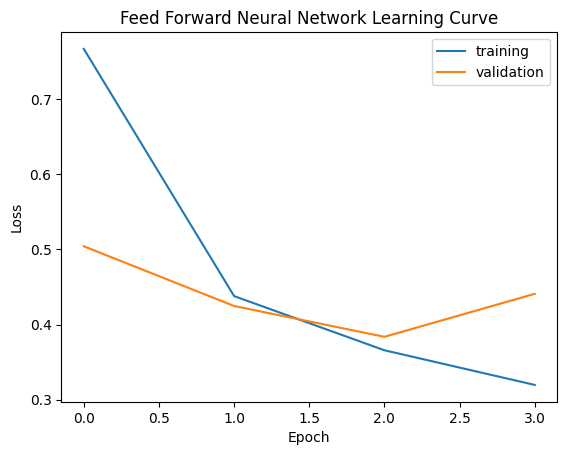

In [17]:
ffnn.plot_learning_curves()

In [18]:
ffnn_pred = ffnn.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [19]:
metrics = evaluate_performance(y_test, ffnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.8480834272829764.
precision	0.8673922771060257.
recall		0.8438908078654238.
f1-score	0.8463243082810062.


In [20]:
ffnn_report = classification_report(y_test, ffnn_pred, target_names=CLASS_NAMES)
print(ffnn_report)

              precision    recall  f1-score   support

         doc       0.96      0.91      0.94       280
         pdf       0.99      0.99      0.99       335
          ps       1.00      0.94      0.97       311
         xls       0.87      0.97      0.91       288
         ppt       0.99      0.86      0.92       337
         swf       0.48      0.83      0.61       283
         gif       0.79      0.54      0.64       301
         jpg       0.89      0.70      0.78       276
         png       0.73      0.66      0.69       260
        html       0.85      0.97      0.90       292
         txt       0.88      0.99      0.93       301
         xml       0.99      0.77      0.87       284

    accuracy                           0.85      3548
   macro avg       0.87      0.84      0.85      3548
weighted avg       0.87      0.85      0.85      3548



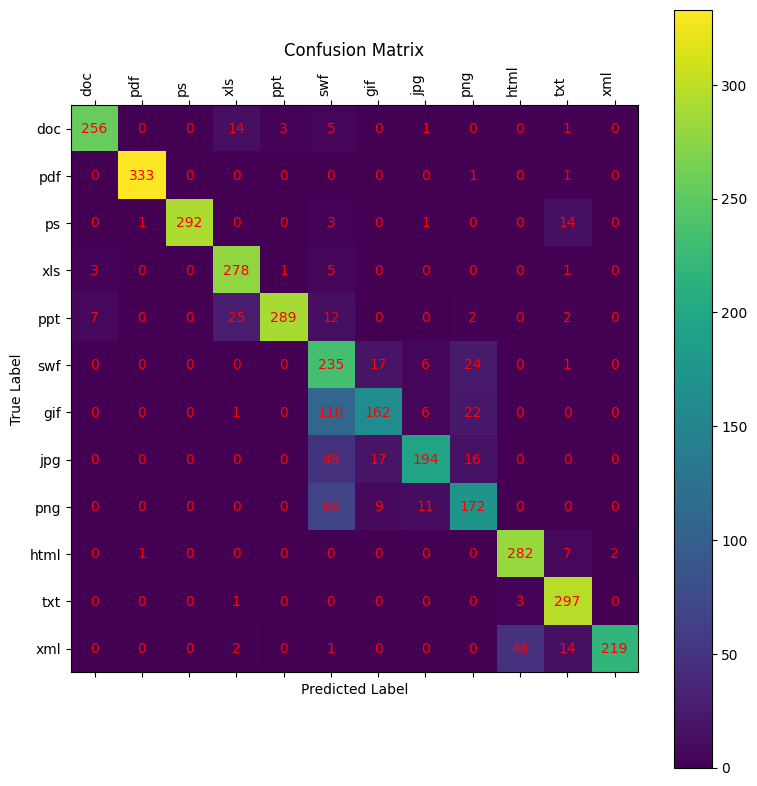

In [21]:
ffnn_cm = confusion_matrix(y_test, ffnn_pred)
plot_confusion_matrix(ffnn_cm, CLASS_NAMES)

#### b. Fine-tuned FFNN

In [22]:
ffnn2 = Ffnn2(timesteps=256, features=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256, 352)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256, 32)        │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │       106,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,509 (462.93 KB)

 Trainable params: 118,509 (462.93 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
ffnn2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6297 - loss: 1.3120 - val_accuracy: 0.8227 - val_loss: 0.5127
Epoch 2/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8345 - loss: 0.4593 - val_accuracy: 0.8472 - val_loss: 0.4413
Epoch 3/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8655 - loss: 0.3941 - val_accuracy: 0.8359 - val_loss: 0.4646
Epoch 4/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8767 - loss: 0.3500 - val_accuracy: 0.8514 - val_loss: 0.4343


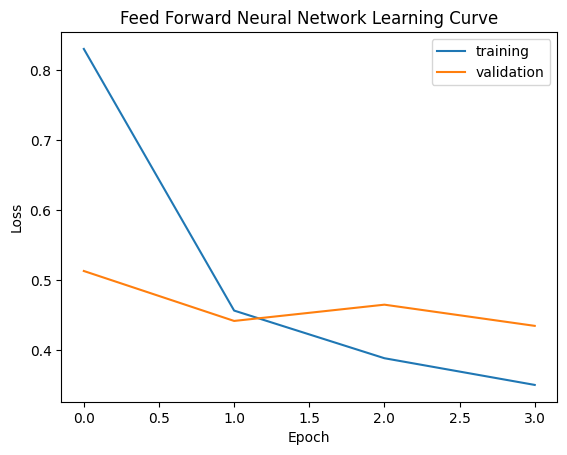

In [24]:
ffnn2.plot_learning_curves()

In [25]:
ffnn2_pred = ffnn2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [26]:
metrics = evaluate_performance(y_test, ffnn2_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn2.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.8644306651634723.
precision	0.8682207101710177.
recall		0.8582412850315753.
f1-score	0.8581979298411325.


In [27]:
ffnn2_report = classification_report(y_test, ffnn2_pred, target_names=CLASS_NAMES)
print(ffnn2_report)

              precision    recall  f1-score   support

         doc       0.89      0.96      0.92       280
         pdf       0.99      0.99      0.99       335
          ps       1.00      0.98      0.99       311
         xls       0.92      0.93      0.93       288
         ppt       0.95      0.89      0.92       337
         swf       0.61      0.63      0.62       283
         gif       0.60      0.78      0.68       301
         jpg       0.78      0.80      0.79       276
         png       0.84      0.49      0.62       260
        html       0.91      0.96      0.93       292
         txt       0.96      0.93      0.95       301
         xml       0.97      0.96      0.96       284

    accuracy                           0.86      3548
   macro avg       0.87      0.86      0.86      3548
weighted avg       0.87      0.86      0.86      3548



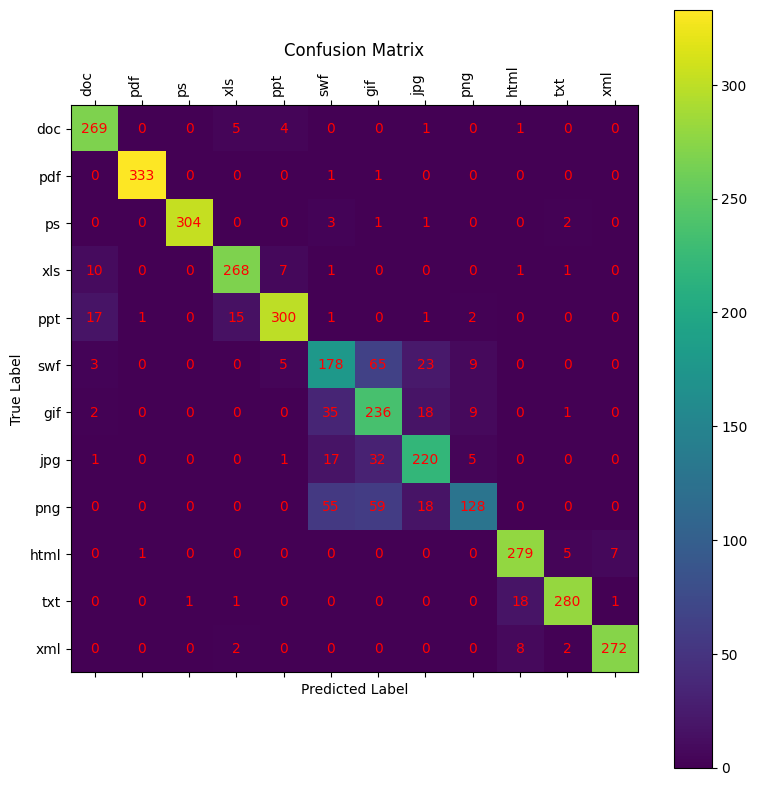

In [28]:
ffnn2_cm = confusion_matrix(y_test, ffnn2_pred)
plot_confusion_matrix(ffnn2_cm, CLASS_NAMES)

### Convolutional Neural Network

#### a. Base CNN

In [29]:
cnn = Cnn(timesteps=256, features=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 254, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │       103,181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,141 (500.55 KB)

 Trainable params: 128,141 (500.55 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6124 - loss: 1.6019 - val_accuracy: 0.7869 - val_loss: 0.6371
Epoch 2/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8283 - loss: 0.5126 - val_accuracy: 0.8215 - val_loss: 0.5368
Epoch 3/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8558 - loss: 0.4187 - val_accuracy: 0.8385 - val_loss: 0.4734
Epoch 4/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8905 - loss: 0.3334 - val_accuracy: 0.8497 - val_loss: 0.4479


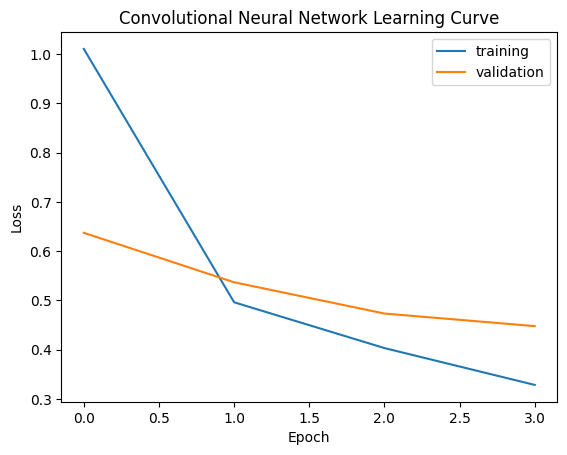

In [31]:
cnn.plot_learning_curves()

In [32]:
cnn_pred = cnn.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [33]:
metrics = evaluate_performance(y_test, cnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.8754227733934611.
precision	0.8738413117874467.
recall		0.8714395430020092.
f1-score	0.8715057305690518.


In [34]:
cnn_report = classification_report(y_test, cnn_pred, target_names=CLASS_NAMES)
print(cnn_report)

              precision    recall  f1-score   support

         doc       0.95      0.94      0.95       280
         pdf       0.99      0.99      0.99       335
          ps       0.99      0.98      0.99       311
         xls       0.91      0.94      0.93       288
         ppt       0.96      0.92      0.94       337
         swf       0.65      0.67      0.66       283
         gif       0.78      0.68      0.72       301
         jpg       0.82      0.78      0.80       276
         png       0.60      0.74      0.66       260
        html       0.96      0.90      0.93       292
         txt       0.96      0.95      0.96       301
         xml       0.90      0.96      0.93       284

    accuracy                           0.88      3548
   macro avg       0.87      0.87      0.87      3548
weighted avg       0.88      0.88      0.88      3548



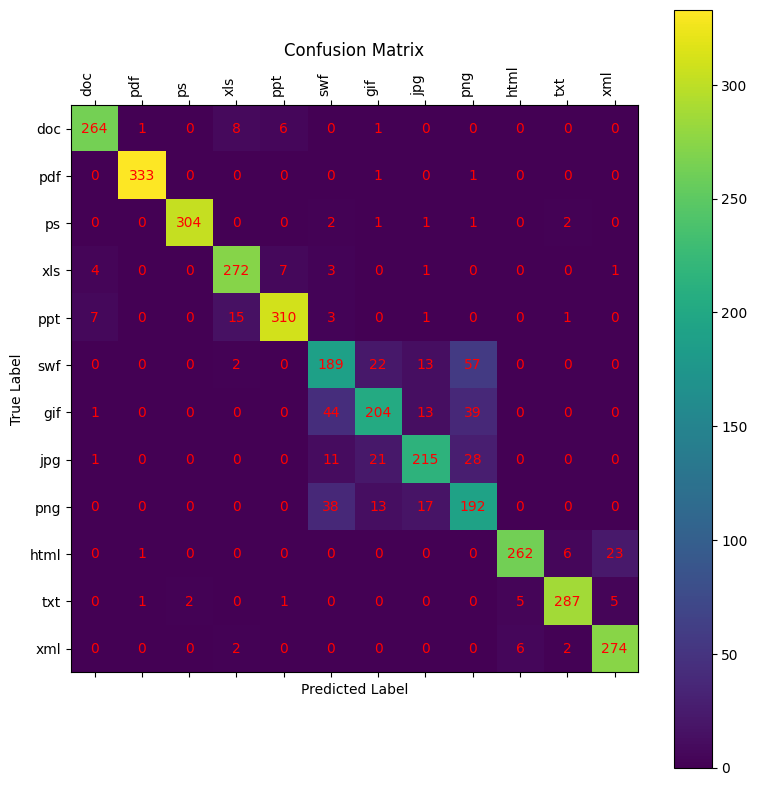

In [35]:
cnn_cm = confusion_matrix(y_test, cnn_pred)
plot_confusion_matrix(cnn_cm, CLASS_NAMES)

#### b. Fine-tuned CNN

In [36]:
cnn2 =  Cnn2(timesteps=256, features=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 254, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 125, 192)       │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     3,047,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,088,333 (11.78 MB)

 Trainable params: 3,088,333 (11.78 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
cnn2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=6,
    batch_size=32
)

Epoch 1/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.5837 - loss: 2.2163 - val_accuracy: 0.7668 - val_loss: 0.6433
Epoch 2/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.8063 - loss: 0.5435 - val_accuracy: 0.8080 - val_loss: 0.5138
Epoch 3/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.8532 - loss: 0.4038 - val_accuracy: 0.8458 - val_loss: 0.4513
Epoch 4/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8787 - loss: 0.3439 - val_accuracy: 0.8063 - val_loss: 0.5261
Epoch 5/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.8895 - loss: 0.3111 - val_accuracy: 0.8664 - val_loss: 0.4279
Epoch 6/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9140 - loss: 0.2461 - val_accuracy: 0.8703 - val_loss: 0.3917


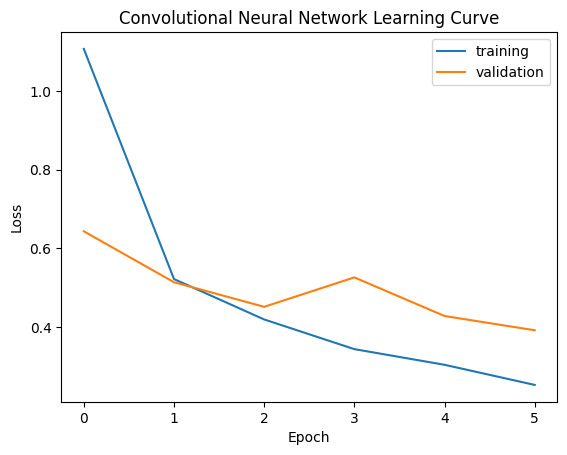

In [38]:
cnn2.plot_learning_curves()

In [39]:
cnn2_pred = cnn2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [40]:
metrics = evaluate_performance(y_test, cnn2_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn2.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.8883878241262683.
precision	0.8848494413508083.
recall		0.8843013419486064.
f1-score	0.8837675458460037.


In [41]:
cnn2_report = classification_report(y_test, cnn2_pred, target_names=CLASS_NAMES)
print(cnn2_report)

              precision    recall  f1-score   support

         doc       0.95      0.96      0.96       280
         pdf       0.99      1.00      1.00       335
          ps       0.99      0.98      0.98       311
         xls       0.94      0.95      0.95       288
         ppt       0.96      0.93      0.95       337
         swf       0.71      0.68      0.70       283
         gif       0.82      0.71      0.76       301
         jpg       0.73      0.83      0.78       276
         png       0.64      0.70      0.67       260
        html       0.97      0.93      0.95       292
         txt       0.96      0.96      0.96       301
         xml       0.94      0.97      0.96       284

    accuracy                           0.89      3548
   macro avg       0.88      0.88      0.88      3548
weighted avg       0.89      0.89      0.89      3548



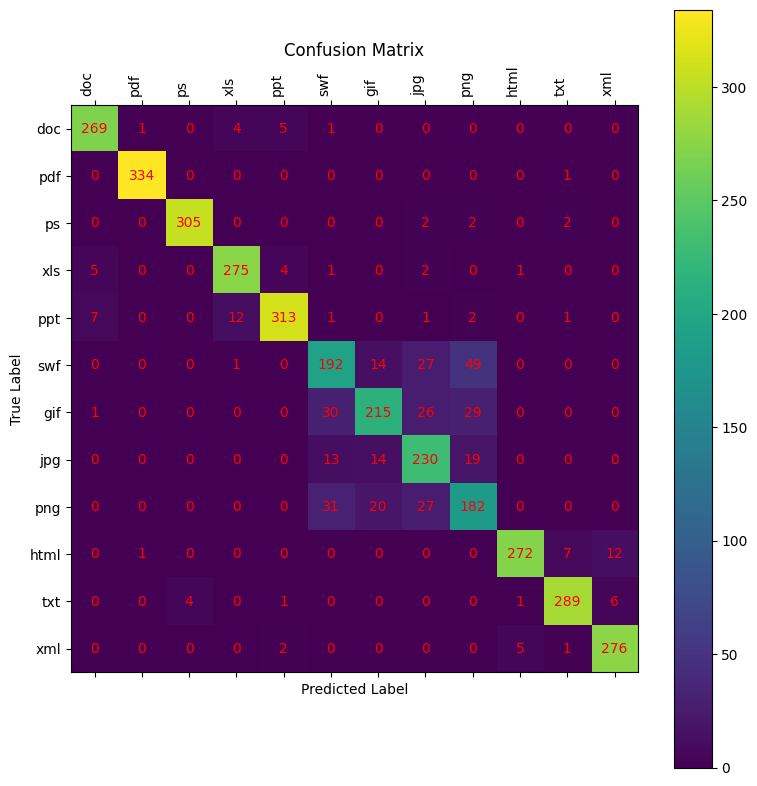

In [42]:
cnn2_cm = confusion_matrix(y_test, cnn2_pred)
plot_confusion_matrix(cnn2_cm, CLASS_NAMES)

### Gated Reccurent Unit

In [43]:
gru = Gru(timesteps=256, features=1)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 136)            │        28,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,749 (120.11 KB)

 Trainable params: 30,749 (120.11 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 89s 164ms/step - accuracy: 0.3217 - loss: 1.6921 - val_accuracy: 0.5540 - val_loss: 1.1215
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.5828 - loss: 1.0647 - val_accuracy: 0.6552 - val_loss: 0.8867
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.6327 - loss: 0.9151 - val_accuracy: 0.6761 - val_loss: 0.8119
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.6861 - loss: 0.7986 - val_accuracy: 0.7090 - val_loss: 0.7534
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 84s 163ms/step - accuracy: 0.7124 - loss: 0.7449 - val_accuracy: 0.7223 - val_loss: 0.7175
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 84s 162ms/step - accuracy: 0.7468 - loss: 0.6629 - val_accuracy: 0.7403 - val_loss: 0.6587
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 87s 168ms/step - accuracy: 0.7588 - loss: 0.6400 - val_accuracy: 0.7626 - val_loss: 0.6315
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 88s 169ms/step - accuracy: 0.7792 - loss: 0

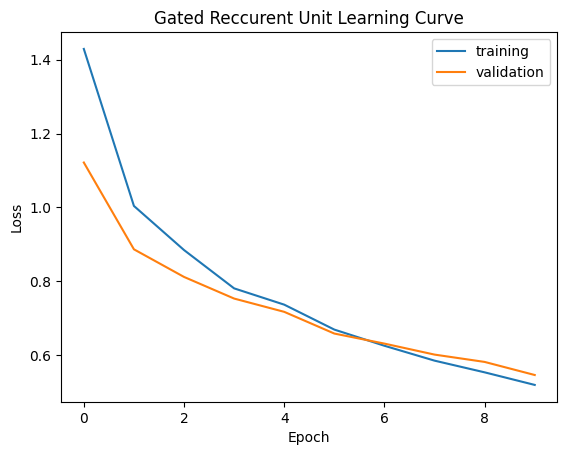

In [45]:
gru.plot_learning_curves()

In [46]:
gru_pred = gru.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step


In [47]:
metrics = evaluate_performance(y_test, gru_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{gru.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Gated Reccurent Unit performance evaluation:

accuracy	0.8091882750845547.
precision	0.804715164211164.
recall		0.8031156746829468.
f1-score	0.8026471812128637.


In [48]:
gru_report = classification_report(y_test, gru_pred, target_names=CLASS_NAMES)
print(gru_report)

              precision    recall  f1-score   support

         doc       0.85      0.85      0.85       280
         pdf       0.94      0.98      0.96       335
          ps       0.91      0.90      0.91       311
         xls       0.86      0.83      0.85       288
         ppt       0.87      0.83      0.85       337
         swf       0.64      0.65      0.65       283
         gif       0.73      0.88      0.80       301
         jpg       0.70      0.60      0.65       276
         png       0.59      0.59      0.59       260
        html       0.90      0.80      0.85       292
         txt       0.84      0.83      0.84       301
         xml       0.83      0.88      0.85       284

    accuracy                           0.81      3548
   macro avg       0.80      0.80      0.80      3548
weighted avg       0.81      0.81      0.81      3548



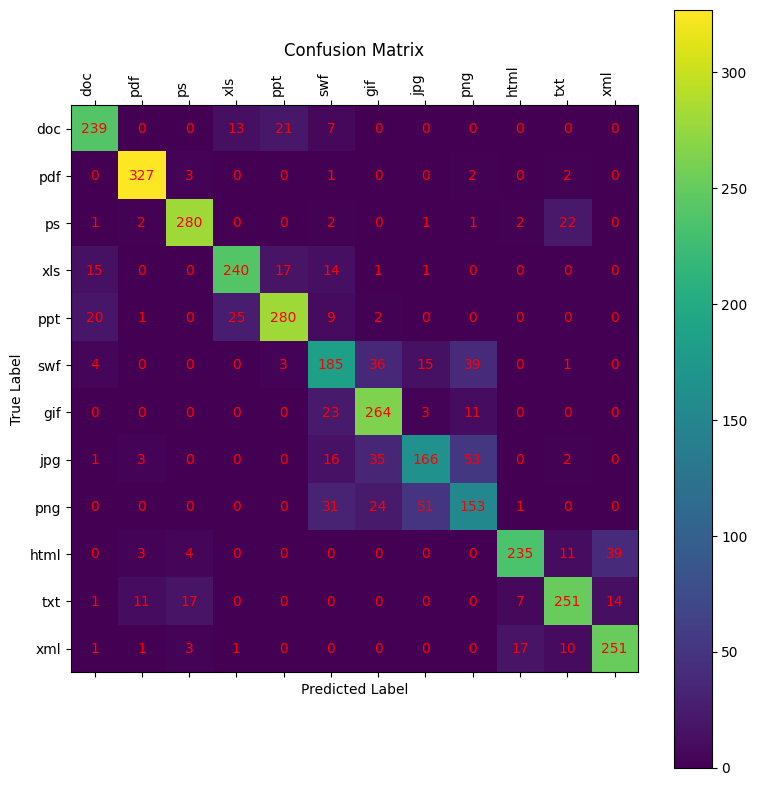

In [49]:
gru_cm = confusion_matrix(y_test, gru_pred)
plot_confusion_matrix(gru_cm, CLASS_NAMES)

### Long Short-Term Memory

In [50]:
lstm = Lstm(timesteps=256, features=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 136)            │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,861 (155.71 KB)

 Trainable params: 39,861 (155.71 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.3195 - loss: 1.6494 - val_accuracy: 0.4934 - val_loss: 1.2346
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 69s 133ms/step - accuracy: 0.4997 - loss: 1.2113 - val_accuracy: 0.5579 - val_loss: 1.0838
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 72s 139ms/step - accuracy: 0.5845 - loss: 1.0121 - val_accuracy: 0.6456 - val_loss: 0.9149
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 72s 139ms/step - accuracy: 0.6198 - loss: 0.9339 - val_accuracy: 0.5266 - val_loss: 1.1825
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 136ms/step - accuracy: 0.6277 - loss: 0.9476 - val_accuracy: 0.6685 - val_loss: 0.8442
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 72s 138ms/step - accuracy: 0.6985 - loss: 0.7967 - val_accuracy: 0.7037 - val_loss: 0.7532
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 136ms/step - accuracy: 0.7213 - loss: 0.7372 - val_accuracy: 0.7195 - val_loss: 0.7071
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - accuracy: 0.7376 - loss: 0

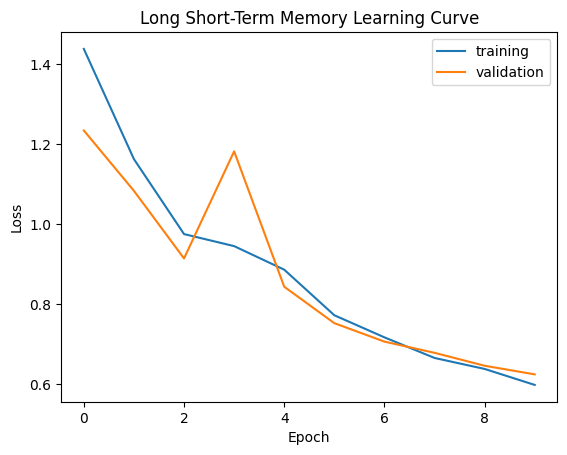

In [52]:
lstm.plot_learning_curves()

In [53]:
lstm_pred = lstm.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step


In [54]:
metrics = evaluate_performance(y_test, lstm_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{lstm.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Long Short-Term Memory performance evaluation:

accuracy	0.7736753100338218.
precision	0.7718249779434169.
recall		0.7659803961995385.
f1-score	0.7649413266332744.


In [55]:
lstm_report = classification_report(y_test, lstm_pred, target_names=CLASS_NAMES)
print(lstm_report)

              precision    recall  f1-score   support

         doc       0.85      0.79      0.82       280
         pdf       0.96      0.96      0.96       335
          ps       0.92      0.89      0.90       311
         xls       0.78      0.80      0.79       288
         ppt       0.78      0.80      0.79       337
         swf       0.55      0.71      0.62       283
         gif       0.75      0.76      0.76       301
         jpg       0.63      0.67      0.65       276
         png       0.56      0.37      0.45       260
        html       0.89      0.73      0.80       292
         txt       0.74      0.91      0.81       301
         xml       0.84      0.81      0.82       284

    accuracy                           0.77      3548
   macro avg       0.77      0.77      0.76      3548
weighted avg       0.78      0.77      0.77      3548



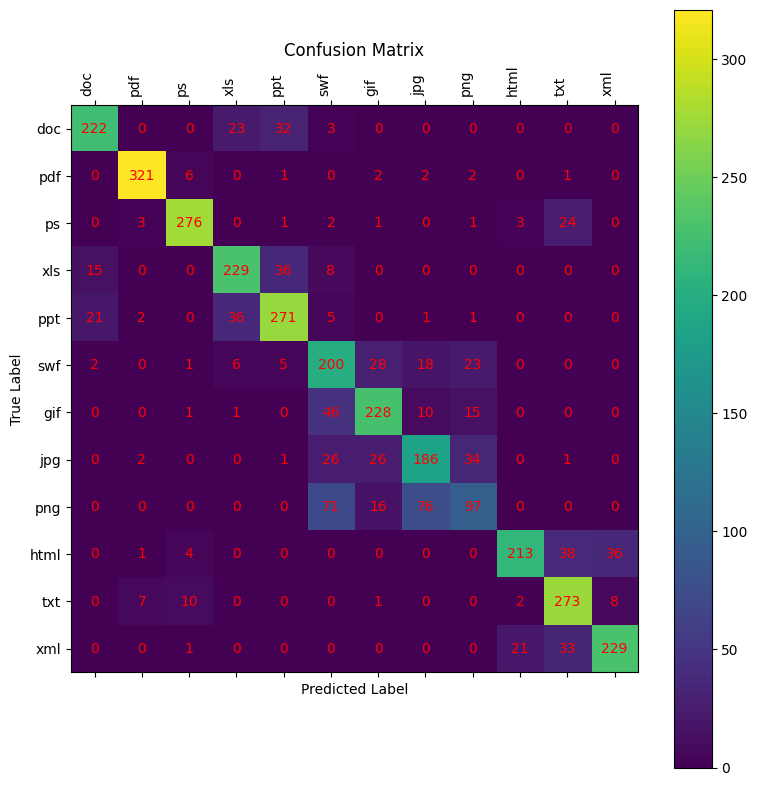

In [56]:
lstm_cm = confusion_matrix(y_test, lstm_pred)
plot_confusion_matrix(lstm_cm, CLASS_NAMES)